## Predicting Walmart's Quarterly Earnings - Pytorch LSTM Example
### Applying LSTMs to Predict Quarterly Earnings

This is the code accompanying my Medium article which you can find linked in the ReadMe. The code blocks follow the same pattern as those in the article!

In [74]:
#@title -- Necessary Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [77]:
#@title Walmart Data
url = 'https://raw.githubusercontent.com/rian-dolphin/Walmart_LSTM/main/WMT_Earnings.csv'
url = "https://raw.githubusercontent.com/onejbsmith/ExportedData/main/output.csv"
df = pd.read_csv(url, index_col='DateTime',parse_dates=True)


#-- Using this we can select the amount of data to use, some of the very early years 
#- aren't formatted properly and will throw an error
#df=df.iloc[:50]
#-- Change the dates into a format that pandas will recognise
#df.index = [df.index[i].split()[0]+" "+df.index[i].split()[2] for i# in range(len(df.index))]
#-- Set index to correct format
#df.index = pd.to_datetime(df['DateTime'])
#-- Put the data in chronological order
#df = df.iloc[::-1]
#-- Only select data up to end of 2019
#df = df[:"2019"]
#-- Remove the B (standing for billion) from the values and store as float rather than a string
#df.Value = [float(df.Value[i][:-1]) for i in range(len(df.Value))]

print(df)

                        close
DateTime                     
2023-03-27 15:09:00  12835.25
2023-03-27 15:10:00  12825.75
2023-03-27 15:11:00  12833.00
2023-03-27 15:12:00  12843.50
2023-03-27 15:13:00  12845.75
...                       ...
2023-03-27 18:12:00  12808.00
2023-03-27 18:13:00  12811.75
2023-03-27 18:14:00  12816.25
2023-03-27 18:15:00  12813.50
2023-03-27 18:16:00  12819.75

[188 rows x 1 columns]


In [ ]:
#@title import Nasdaq index data, visualize
#Coverts tick data to data frame with date Time column

url = "https://raw.githubusercontent.com/onejbsmith/ExportedData/main/MNQ%2006-23-032723-tick.Last.2.csv"
df = pd.read_csv(url,parse_dates={'DateTime':['Day',' Time']})
LIMIT = 250000
df = df[:LIMIT]
print(df)

In [ ]:
#@title Turn data to candles

df = df.assign(Timestamp = pd.to_datetime(df['DateTime'],unit='m')).set_index('DateTime')


candle_duration = '1T';
candle_column = ' Last'
#candle_column = ' Bid'
df = df.resample(candle_duration)[candle_column].ohlc()

print(df)

In [ ]:
#@title Reduce to single column, Value

print (df['close'])
#df = [float(df.Value[i][:-1]) for i in range(len(df.Value))]
#df.Value = [float(df['close'][i][:-1]) for i in range(len(df['close']))]

#print(df) 



In [64]:
#@title Write to file

from google.colab import files
df['close'].to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test
test_periods = 8
train, test = train_test(df, test_periods)

print(train)

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [80]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([180, 1])
Correct dimensions : torch.Size([180])


In [81]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 16 #-- number of quarters for input
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([156, 16])
torch.Size([156, 8])


In [82]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), 
                                          self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [83]:
model = LSTM(input_size=1, hidden_size=50, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
epochs = 600
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.00785686
epoch:  100 loss:0.01266602
epoch:  200 loss:0.00887423
epoch:  300 loss:0.00392420
epoch:  400 loss:0.00149685
epoch:  500 loss:0.00040660
epoch:  600 loss:0.00044032


In [130]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-train_periods:], None)
#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))

predictions

df[:-len(predictions)]

df.index

x = [dt.datetime.time(d) for d in df.index]

x[:-len(predictions)] #
#x.strptime("%H:%M:%S.%f")
#str(x[:-len(predictions)][10])

#str(x)[:-len(predictions)]
a = []
for t in x:
 a.append( str(t))

x = a
x[:-len(predictions)]

['15:09:00',
 '15:10:00',
 '15:11:00',
 '15:12:00',
 '15:13:00',
 '15:14:00',
 '15:15:00',
 '15:16:00',
 '15:17:00',
 '15:18:00',
 '15:19:00',
 '15:20:00',
 '15:21:00',
 '15:22:00',
 '15:23:00',
 '15:24:00',
 '15:25:00',
 '15:26:00',
 '15:27:00',
 '15:28:00',
 '15:29:00',
 '15:30:00',
 '15:31:00',
 '15:32:00',
 '15:33:00',
 '15:34:00',
 '15:35:00',
 '15:36:00',
 '15:37:00',
 '15:38:00',
 '15:39:00',
 '15:40:00',
 '15:41:00',
 '15:42:00',
 '15:43:00',
 '15:44:00',
 '15:45:00',
 '15:46:00',
 '15:47:00',
 '15:48:00',
 '15:49:00',
 '15:50:00',
 '15:51:00',
 '15:52:00',
 '15:53:00',
 '15:54:00',
 '15:55:00',
 '15:56:00',
 '15:57:00',
 '15:58:00',
 '15:59:00',
 '16:00:00',
 '16:01:00',
 '16:02:00',
 '16:03:00',
 '16:04:00',
 '16:05:00',
 '16:06:00',
 '16:07:00',
 '16:08:00',
 '16:09:00',
 '16:10:00',
 '16:11:00',
 '16:12:00',
 '16:13:00',
 '16:14:00',
 '16:15:00',
 '16:16:00',
 '16:17:00',
 '16:18:00',
 '16:19:00',
 '16:20:00',
 '16:21:00',
 '16:22:00',
 '16:23:00',
 '16:24:00',
 '16:25:00',

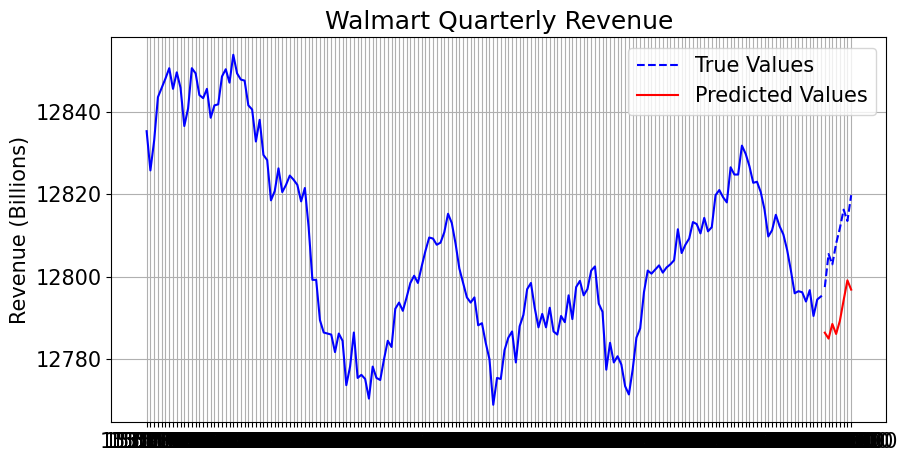

In [131]:
#x = [dt.datetime.date(d) for d in df.index]
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Walmart Quarterly Revenue')
plt.ylabel('Revenue (Billions)')
plt.grid(True)
plt.plot(x[:-len(predictions)],
         df['close'][:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         df['close'][-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)